In [1]:
import torch
from models.base import BaseVAE
from torch import nn
from torch.nn import functional as F
from models.types_ import *

import numpy as np
import os
import cv2
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# old VAE architecture

class ResidualBlockEncoder(nn.Module):
    
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 stride: int,
                 **kwargs) -> None:
        super(ResidualBlockEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                              kernel_size= 3, padding  = 1)
        self.conv2 = nn.Conv2d(in_channels, out_channels,
                              kernel_size= 3, padding  = 1)
        self.norm = nn.BatchNorm2d(in_channels)
        self.pool = nn.MaxPool2d(self.stride)
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.norm(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            temp = self.pool(self.conv2(x))
        else: temp = 1*x
        x = self.relu(self.pool(self.conv1(x)))
        x = x + temp
        return x
    
    
class ResidualBlockDecoder(nn.Module):
    
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 stride: int,
                 **kwargs) -> None:
        super(ResidualBlockDecoder, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        self.conv1 = nn.ConvTranspose2d(in_channels, 
                                        out_channels,
                                        kernel_size= 3, 
                                        stride= stride, 
                                        padding  = 1,
                                        output_padding=stride-1)
        
        self.conv2 = nn.ConvTranspose2d(in_channels, 
                                        out_channels,
                                        kernel_size= 3, 
                                        stride= stride, 
                                        padding  = 1,
                                        output_padding=stride-1)
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.norm(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            temp = self.conv2(x)
        else: temp = 1*x
        x = self.relu(self.conv1(x))
        x = x + temp
        return x

        
class VAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 in_size: int, 
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.nb_last_channels = hidden_dims[-1]
        self.out_channels = in_channels
        

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
            div = 2**5  # Model reduces size by this factor           
        else:
            div = 2**len(hidden_dims)   # Model reduces size by this factor   
            
        # Make sure input dimension is usable     
        if in_size%div==0:
            self.smallest_size = int(in_size/div)
        else: raise ValueError('Input size not compatible with number of hidden layers.')

            

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    ResidualBlockEncoder(in_channels=in_channels, out_channels=in_channels, stride= 1),
                    ResidualBlockEncoder(in_channels=in_channels, out_channels=in_channels, stride= 1),
                    ResidualBlockEncoder(in_channels=in_channels, out_channels=h_dim, stride= 2))
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        #self.fc_mu = nn.Linear(hidden_dims[-1]*self.smallest_size**2, latent_dim)
        #self.fc_var = nn.Linear(hidden_dims[-1]*self.smallest_size**2, latent_dim)
        

        # Build Decoder
        modules = []

        #self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * self.smallest_size**2)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    ResidualBlockDecoder(hidden_dims[i], hidden_dims[i], stride = 1),
                    ResidualBlockDecoder(hidden_dims[i], hidden_dims[i], stride = 1),
                    ResidualBlockDecoder(hidden_dims[i], hidden_dims[i+1], stride = 2))
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= self.out_channels,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        #mu = self.fc_mu(result)
        #log_var = self.fc_var(result)
        mu = float('nan')
        log_var = float('nan')

        return [result, mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        #result = self.decoder_input(z)
        result = z
        result = result.view(-1, self.nb_last_channels, self.smallest_size, self.smallest_size)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        result, mu, log_var = self.encode(input)
        #z = self.reparameterize(mu, log_var)
        return  [self.decode(result), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)
        #recons_loss = F.l1_loss(recons, input)


        #kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        kld_loss = float('nan')
        
        #loss = recons_loss + kld_weight * kld_loss
        loss = float('nan')
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [2]:
# VAE architecture with conv layers for log_var and mu


import torch
from torch import nn
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')



class ResidualBlockEncoder(nn.Module):
    
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 stride: int,
                 **kwargs) -> None:
        super(ResidualBlockEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                              kernel_size= 3, stride= stride, padding  = 1)
        self.conv2 = nn.Conv2d(in_channels, out_channels,
                              kernel_size= 3, stride= stride, padding  = 1)
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.norm(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            temp = self.conv2(x)
        else: temp = 1*x
        x = self.relu(self.conv1(x))
        x = x + temp
        return x
    
    
class ResidualBlockDecoder(nn.Module):
    
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 stride: int,
                 **kwargs) -> None:
        super(ResidualBlockDecoder, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        self.conv1 = nn.ConvTranspose2d(in_channels, 
                                        out_channels,
                                        kernel_size= 3, 
                                        stride= stride, 
                                        padding  = 1,
                                        output_padding=stride-1)
        
        self.conv2 = nn.ConvTranspose2d(in_channels, 
                                        out_channels,
                                        kernel_size= 3, 
                                        stride= stride, 
                                        padding  = 1,
                                        output_padding=stride-1)
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.norm(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            temp = self.conv2(x)
        else: temp = 1*x
        x = self.relu(self.conv1(x))
        x = x + temp
        return x

        
class VAE(nn.Module):

    def __init__(self,
                 in_channels: int,
                 in_size: int, 
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VAE, self).__init__()

        self.nb_last_channels = hidden_dims[-1]
        self.out_channels = in_channels
        

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
            div = 2**5  # Model reduces size by this factor           
        else:
            div = 2**len(hidden_dims)   # Model reduces size by this factor   
            
        # Make sure input dimension is usable     
        if in_size%div==0:
            self.smallest_size = int(in_size/div)
        else: raise ValueError('Input size not compatible with number of hidden layers.')

#*
        self.latent_dim = hidden_dims[-1] * self.smallest_size**2
#d        self.latent_dim = self.smallest_size**2

            

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    ResidualBlockEncoder(in_channels=in_channels, out_channels=in_channels, stride= 1),
                    ResidualBlockEncoder(in_channels=in_channels, out_channels=in_channels, stride= 1),
                    ResidualBlockEncoder(in_channels=in_channels, out_channels=h_dim, stride= 2))
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
#*  
        self.fc_mu = nn.Conv2d(hidden_dims[-1], hidden_dims[-1], kernel_size= 3, stride= 1, padding  = 1)
        self.fc_var = nn.Conv2d(hidden_dims[-1], hidden_dims[-1], kernel_size= 3, stride= 1, padding  = 1)
        
#d        self.decoder_input = nn.Conv2d(1, hidden_dims[-1], kernel_size= 3, stride= 1, padding  = 1)


        # Build Decoder
        modules = []

#        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * self.smallest_size**2)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    ResidualBlockDecoder(hidden_dims[i], hidden_dims[i], stride = 1),
                    ResidualBlockDecoder(hidden_dims[i], hidden_dims[i], stride = 1),
                    ResidualBlockDecoder(hidden_dims[i], hidden_dims[i+1], stride = 2))
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= self.out_channels,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
#        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
#*        
        mu = torch.flatten(self.fc_mu(result), start_dim=1)
#d        mu = torch.flatten(torch.mean(result, dim=1), start_dim=1)
#*
        log_var = torch.flatten(self.fc_var(result), start_dim=1)
#d        log_var = torch.flatten(torch.std(result,dim=1), start_dim=1)
  

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = z
#d        result = result.view(-1, 1, self.smallest_size, self.smallest_size)
#d        result = self.decoder_input(result)
#*
        result = result.view(-1, self.nb_last_channels, self.smallest_size, self.smallest_size)

        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [3]:
class Crop:
    """
    Crop the input lightfield to a given size with a given position
    """

    def __init__(self, size, pos):
        """
        :param size: output size. Tuple (height, width) or int for square size
        :type size: tuple(h, w) or int

        :param pos: crop position(s) tuple (y, x)
        :type pos: tuple(y, x)
        """
        assert isinstance(size, int) or (
            isinstance(size, tuple) and len(size) == 2)
        assert isinstance(pos, tuple)

        self.size = size
        if isinstance(size, int):
            self.size = (size, size)

        self.pos = pos

    def __call__(self, data):
        """
        Crop the lightfield data.

        :param data: Sequence containing (h_views, v_views, center, gt, index)
                     or any other sequence of images or image stacks
        :type data: tuple

        :returns: the cropped lightfield data
        """
        #data = data
        h, w = self.size
        y, x = self.pos
        shape = list(data.shape)
        shape[-1] = w
        shape[-2] = h
        output = np.empty(tuple(shape))

        for i in range(len(data)):
            shape = data[i].shape
            if len(shape) < 2 or shape[-1] <= 1 or shape[-2] <= 1:
                continue

            output[i] = data[i][..., y:y+h, x:x+w]

        return output

import random

class RandomCrop:
    """
    Crop patches randomly to a given size
    """

    def __init__(self, size, pad=0):
        """
        :param size: output size. Tuple (height, width) or int for square size
        :type size: tuple(h, w) or int

        :param pad: optional padding to not choose samples from
        :tyoe pad: int
        """
        assert isinstance(size, int) or (
            isinstance(size, tuple) and len(size) == 2)

        self.size = size
        if isinstance(size, int):
            self.size = (size, size)

        assert isinstance(pad, int)
        self.pad = pad

    def __call__(self, data):
        """
        Crop the lightfield data.

        :param data: Sequence containing (h_views, v_views, center, gt, index)
                     or any other sequence of images or image stacks
        :type data: tuple

        :returns: the cropped lightfield data
        """
        h = data[0].shape[-2]
        w = data[0].shape[-1]

        assert h > self.size[0]
        assert w > self.size[1]

        y = random.randint(self.pad, h - self.size[0] - self.pad)
        x = random.randint(self.pad, w - self.size[1] - self.pad)

        crop = Crop(self.size, (y, x))

        return crop(data)
    
class RedistColor:
    """
    Randomly redistribute color
    """

    def __call__(self, data):
        """
        Redistribute the lightfield color data.

        :param data: Sequence containing (h_views, v_views, center, gt, index)
        :type data: tuple

        :returns: the recolored lightfield data
        """
        # create redistribution matrix
        mat = np.zeros((3, 3))
        mat[0, 0] = random.uniform(0.0, 1.0)
        mat[0, 1] = random.uniform(0.0, 1.0 - mat[0, 0])
        mat[1, 0] = random.uniform(0.0, 1.0 - mat[0, 0])
        mat[1, 1] = random.uniform(0.0, 1.0 - max(mat[0, 1], mat[1, 0]))

        mat[0, 2] = 1.0 - mat[0, 0] - mat[0, 1]
        mat[1, 2] = 1.0 - mat[1, 0] - mat[1, 1]
        mat[2, 0] = 1.0 - mat[0, 0] - mat[1, 0]
        mat[2, 1] = 1.0 - mat[0, 1] - mat[1, 1]
        mat[2, 2] = mat[0, 0] + mat[0, 1] + mat[1, 0] + mat[1, 1] - 1.0

        for i in range(min(5, len(data))):
            if data[i] is None:
                continue
            if isinstance(data[i], np.ndarray):
                stack = data[i].copy()
            else:
                stack = data[i].clone()

            assert stack.shape[-3] == 3

            data[i][..., 0, :, :] = mat[0, 0] * stack[..., 0, :, :]
            data[i][..., 0, :, :] += mat[0, 1] * stack[..., 1, :, :]
            data[i][..., 0, :, :] += mat[0, 2] * stack[..., 2, :, :]

            data[i][..., 1, :, :] = mat[1, 0] * stack[..., 0, :, :]
            data[i][..., 1, :, :] += mat[1, 1] * stack[..., 1, :, :]
            data[i][..., 1, :, :] += mat[1, 2] * stack[..., 2, :, :]

            data[i][..., 2, :, :] = mat[2, 0] * stack[..., 0, :, :]
            data[i][..., 2, :, :] += mat[2, 1] * stack[..., 1, :, :]
            data[i][..., 2, :, :] += mat[2, 2] * stack[..., 2, :, :]

        return data

class Contrast:
    """
    Randomly change Contrast
    """

    def __init__(self, level=0.9):
        """
        :param level: level of change
        :type level: float
        """
        assert isinstance(level, float)
        self.level = level

    def __call__(self, data):
        """
        Change the lightfields contrast.

        :param data: Sequence containing (h_views, v_views, center, gt, index)
        :type data: tuple

        :returns: the recolored lightfield data
        """
        alpha = random.uniform(-self.level, self.level) + 1.0
        mean = data[0].mean()

        for i in range(min(5, len(data))):
            if data[i] is None:
                continue

            data[i] = data[i] * alpha + mean * (1.0 - alpha)

        return data


class Brightness:
    """
    Randomly change Brightness
    """

    def __init__(self, level=0.9):
        """
        :param level: level of change
        :type level: float
        """
        assert isinstance(level, float)
        self.level = level

    def __call__(self, data):
        """
        Change the lightfields brightness.

        :param data: Sequence containing (h_views, v_views, center, gt, index)
        :type data: tuple

        :returns: the recolored lightfield data
        """
        alpha = random.uniform(-self.level, self.level) + 1.0

        for i in range(min(5, len(data))):
            if data[i] is None:
                continue

            data[i] = data[i] * alpha

        return data


class Noise:
    """
    Add random Gaussian noise
    """

    def __init__(self, stdev=0.01):
        """
        :param stdev: standard deviation of noise
        :type stdev: float
        """
        assert isinstance(stdev, float)
        self.stdev = stdev

    def __call__(self, data):
        """
        Add random Gaussian noise.

        :param data: Sequence containing (h_views, v_views, center, gt, index)
        :type data: tuple

        :returns: the recolored lightfield data
        """
        for i in range(min(5, len(data))):
            if data[i] is None:
                continue

            noise = np.random.normal(scale=self.stdev, size=data[i].shape)
            data[i] += noise

        return data

In [4]:
class LightFieldDataset:
    '''
    Dataset class for the Lightfield Dataset.
    '''
    
    def __init__(self, sort = 'training', data_kind = 'grid', root_dir = './data/', transform=None):
        '''
        Args:
            sort (string or list): What sort of data you want to load. Valid input: 'training', 'test', 'stratified', 'additional'.
            data_kind (string): What structure the data should have. Valid input: 'grid', 'hstack', 'vstack', 'stack', 'cross'.
            root_dir (string, optional): the working directory with subdirectories 'training', 'test', etc.
            transform (callable, optional): Optional transform to be applied the data.
        '''
        
        self.data_kind = data_kind
        self.root_dir = root_dir
        self.transform = transform
        self.directory_names = []
        self.images_paths = []
        self.stack_index = []
        
        if type(sort) == str:
            self.images_paths.append(os.path.join(root_dir, sort))
        else:
            for directory in sort:
                self.images_paths.append(os.path.join(root_dir, directory))
        
        # this block just stores the path of each individual scene (=grid)
        # iterates over all entered values in 'sort'.
        for images_path in self.images_paths:
            # safe all the scene names (directories) and all image names of each scene
            # iterate over all directories in images path. Each directory includes the images of *one* scene
            for filename in os.listdir(images_path):
                directory_path = os.path.join(images_path, filename)
                if os.path.isdir(directory_path):
                    if self.data_kind in ['grid', 'cross']:
                        self.directory_names.append(directory_path)
                    elif self.data_kind == 'stack':
                        # for data_kind stack we have 18 stacks per scene, 9 hstacks and 9 vstacks.
                        for i in range(18):
                            self.direcotry_names.append(directory_path)
                            self.stack_index.append(i)
                    else:
                        # for data_kind hstack or vstack, we have 9 stacks per scene, so we need to call each scene
                        # 9 times in __getitem__ and also add a stack_index to know whether images are in the same
                        # stack.
                        for i in range(9):
                            self.directory_names.append(directory_path)
                            self.stack_index.append(i)

    def __len__(self):
        '''
        Returns the lenght of the dataset (number of grid's/ hstack's/ vstack's/ stack's/ crosses)
        '''
        return len(self.directory_names)
    
    def __getitem__(self, index):
        '''
        Returns a whole grid/ vstack/ hstack/ stack/ cross
        '''
        
        final_data = []
        
        if torch.is_tensor(index):
            index = index.tolist()
        
        # iterate over all files for a fixed scene (which is one directory name)
        for imagename in sorted(os.listdir(self.directory_names[index])):
            # read all images
            if imagename[0:5] == 'input':
                if self.data_kind == 'grid':
                    img = cv2.imread(os.path.join(self.directory_names[index], imagename))
                    # To resize all images to a specific shape, uncomment: img = cv2.resize(img, shape)
                    # append each color channel seperately
                    for color in range(3):
                        final_data.append(img[:, :, color]/255)
                else:
                    # get the number of the image and omit the first zero for calculation reasons
                    if imagename[10:12].isdigit():
                        if imagename[10] == '0':
                            image_number = int(imagename[11])
                        else:
                            image_number = int(imagename[10:12])                                
                            
                        if self.data_kind == 'hstack' and np.floor_divide(image_number, 9) == self.stack_index[index]:
                            img = cv2.imread(os.path.join(self.directory_names[index], imagename))
                            for color in range(3):
                                final_data.append(img[:, :, color]/255)
                                
                        if self.data_kind == 'vstack' and image_number % 9 == self.stack_index[index]:
                            img = cv2.imread(os.path.join(self.directory_names[index], imagename))
                            for color in range(3):
                                final_data.append(img[:, :, color]/255)
                                
                        if self.data_kind == 'stack':
                            if self.stack_index[index] <= 8 and np.floor_divide(image_number, 9) == self.stack_index[index]:
                                img = cv2.imread(os.path.join(self.directory_names[index], imagename))
                                for color in range(3):
                                    final_data.append(img[:, :, color]/255)
                            if self.stack_index[index] > 8:
                                custom_stack_index = self.stack_index[index] - 9
                                if image_number % 9 == custom_stack_index:
                                    img = cv2.imread(os.path.join(self.directory_names[index], imagename))
                                    for color in range(3):
                                        final_data.append(img[:, :, color]/255)
                        
                        if self.data_kind == 'cross' and ((np.floor_divide(image_number, 9) == 4) or 
                                                     (image_number != 40 and image_number % 9 == 4)):
                            img = cv2.imread(os.path.join(self.directory_names[index], imagename))
                            for color in range(3):
                                final_data.append(img[:, :, color]/255)
        
        # in the 'cross' case the images got appended from vertical to horizontal, but we swap it the other way around
        if self.data_kind == 'cross':
            final_data = final_data[4:13] + final_data[0:4] + final_data[13:]
            
        final_data = np.array(final_data)
                    
        if self.transform:
            final_data = self.transform(final_data)
        
        return final_data

In [5]:
# Define Trainer

from torchvision.utils import save_image

collect_test_loss=[]
collect_train_loss=[]

# Achtung: Momentan wird im Trainer nur Reconstruction Loss verwendet
class Trainer(object):
    def __init__(self, model,
                 optimizer, loss_function,
                 loader_train, loader_val,
                 dtype, device, **in_params):
        """
        :param model: PyTorch model of the neural network

        :param optimizer: PyTorch optimizer

        :param print_every: How often should we print the loss during training
        """
        # Create attributes:
        self.device = device
        self.model = model.to(device=self.device)  # move the model parameters to CPU/GPU
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.loader_train = loader_train
        self.loader_val = loader_val
        self.print_every = in_params["print_every"]
        self.dtype = dtype
        self.batch_size = in_params["batch_size"]
        self.input_size = in_params["input_size"]
        self.path = in_params["path"]


    def train_model(self, epoch):
        """
        - epoch: An integer giving the epoch
        """
        train_loss = 0
        self.model.train()  # put model to training mode
        for t, input in enumerate(self.loader_train):
            
            input = input.to(device=self.device, dtype=self.dtype)  # move to device, e.g. GPU
            
            # do a step in training
            args = self.model(input)
            loss = self.loss_function(*args,**{'M_N':self.batch_size/len(self.loader_train)})['Reconstruction_Loss']
            self.optimizer.zero_grad()
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(self.model.parameters(),1)
            train_loss += loss.item() # accumulate for average loss
            self.optimizer.step()

            # print loss
            if t % self.print_every == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, t * len(args[1]), len(self.loader_train.dataset),
                    100. * t / len(self.loader_train),
                    loss.item() / len(args[1])))
        # print average loss
        collect_train_loss.append(train_loss / len(self.loader_train.dataset))
        print('====> Epoch: {} Average loss: {:.6f}'.format(
              epoch, train_loss / len(self.loader_train.dataset)))

    def test_model(self, epoch):
        self.model.eval() # Put model to evaluation mode
        test_loss = 0.

        with torch.no_grad():
            # During validation, we accumulate these values across the whole dataset and then average at the end:
            for i, input in enumerate(self.loader_val):
                input = input.to(device=self.device, dtype=self.dtype)  # move to device, e.g. GPU
       
                # compute loss and accumulate
                args = self.model(input)
                #print('args:',len(args))
                test_loss += self.loss_function(*args,**{'M_N':self.batch_size/len(self.loader_val)})['Reconstruction_Loss'].item()
                if i == 0 and epoch % 20 == 0:
                    n = min(args[1].size(0), 1)
                    
                    #save only one image
                 #   comparison = torch.cat([args[1][:n,:3,:,:],
                 #                         args[0].view(self.batch_size, self.model.out_channels, self.input_size, self.input_size)[:n,:3,:,:]])
                   
                    # save whole stack
                    original_img = args[1][:n]
                    original_img = torch.reshape(original_img, (9, 3, self.input_size, self.input_size))
                    reconstructed_img = args[0][:n].view(self.model.out_channels, self.input_size, self.input_size)
                    reconstructed_img = torch.reshape(reconstructed_img, (9, 3, self.input_size, self.input_size))
                    comparison = torch.cat([original_img, reconstructed_img],-1)
                    save_image(comparison.cpu(),
                             self.path + '/reconstruction_' + str(epoch) + '.png', nrow=n)

        # print average loss
        test_loss /= len(self.loader_val.dataset)
        collect_test_loss.append(test_loss)
        print('====> Test set loss: {:.6f}'.format(test_loss))

        
    def train_and_test(self, epochs):
        for e in range(1,epochs+1):
            self.train_model(e)
            if ((e) %1 == 0): self.test_model(e)
            if ((e) % 10 == 0):
                with torch.no_grad():
                    sample = self.model.sample(64, device)
#                    save_image(sample.view(64, self.model.out_channels, self.input_size, self.input_size), self.path + '/sample_' + str(e) + '.png')
                    save_image(sample[:, :3, :, :], self.path + '/sample_' + str(e) + '.png')

In [ ]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# train_and_test takes two paths where it will save the loss plot
class Trainer(object):
    def __init__(self, model,
                 optimizer, loss_function,
                 loader_train, loader_val,
                 dtype, device, **in_params):
        """
        :param model: PyTorch model of the neural network

        :param optimizer: PyTorch optimizer

        :param print_every: How often should we print the loss during training
        """
        # Create attributes:
        self.device = device
        self.model = model.to(device=self.device)  # move the model parameters to CPU/GPU
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.loader_train = loader_train
        self.loader_val = loader_val
        self.print_every = in_params["print_every"]
        self.dtype = dtype
        self.batch_size = in_params["batch_size"]
        self.input_size = in_params["input_size"]
        self.path = in_params["path"]
        self.collect_test_loss=[]
        self.collect_train_loss=[]


    def train_model(self, epoch):
        """
        - epoch: An integer giving the epoch
        """
        train_loss = 0
        self.model.train()  # put model to training mode
        for t, input in enumerate(self.loader_train):
            
            input = input.to(device=self.device, dtype=self.dtype)  # move to device, e.g. GPU
            
            # do a step in training
            args = self.model(input)
            loss = self.loss_function(*args,**{'M_N':1e-4*self.batch_size/len(self.loader_train)})['loss']
            self.optimizer.zero_grad()
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(self.model.parameters(),1)
            train_loss += loss.item() # accumulate for average loss
            self.optimizer.step()

            # print loss
            if t % self.print_every == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, t * len(args[1]), len(self.loader_train.dataset),
                    100. * t / len(self.loader_train),
                    loss.item() / len(args[1])))
        # print average loss
        self.collect_train_loss.append(train_loss / len(self.loader_train.dataset))
        print('====> Epoch: {} Average loss: {:.6f}'.format(
              epoch, train_loss / len(self.loader_train.dataset)))

    def test_model(self, epoch):
        self.model.eval() # Put model to evaluation mode
        test_loss = 0.

        with torch.no_grad():
            # During validation, we accumulate these values across the whole dataset and then average at the end:
            for i, input in enumerate(self.loader_val):
                input = input.to(device=self.device, dtype=self.dtype)  # move to device, e.g. GPU
       
                # compute loss and accumulate
                args = self.model(input)
                test_loss += self.loss_function(*args,**{'M_N':1e-4*self.batch_size/len(self.loader_val)})['loss'].item()
                if i == 0 and epoch%10 == 0:
                    n = min(args[1].size(0), 6)
                    comparison = torch.cat([args[1][:n],
                                          args[0].view(self.batch_size, self.model.out_channels, self.input_size, self.input_size)[:n]])
                    save_image(comparison.cpu(),
                             self.path + '/reconstruction_' + str(epoch) + '.png', nrow=n)

        # print average loss
        self.collect_test_loss.append(test_loss)
        test_loss /= len(self.loader_val.dataset)
        print('====> Test set loss: {:.6f}'.format(test_loss))
        
    def train_and_test(self, epochs, path1, path2):

        for e in range(1,epochs+1):
            self.train_model(e)
            self.test_model(e)
            if e%10 == 0:
                with torch.no_grad():
                    sample = self.model.sample(64, device)
                    save_image(sample[:, :3, :, :], self.path + '/sample_' + str(e) + '.png')

        with torch.no_grad():
          trloss = self.collect_train_loss
          teloss = self.collect_test_loss
          print(np.min(trloss),np.min(teloss))

          n1 = len(trloss)
          n2 = len(teloss)

          plt.yscale('log')
          plt.plot(np.arange(n1), trloss)
          plt.grid()
          plt.title('average train loss')
          plt.savefig(path1)
          plt.show()

          plt.yscale('log')
          plt.plot(np.arange(n2), teloss)
          plt.grid()
          plt.title('test loss')
          plt.savefig(path2)
          plt.show()

In [9]:
# Train VAE

from torchvision import datasets, transforms

in_params = {"batch_size": 90,
        "epochs": 2000,
        "no_cuda": False,
        "seed": 1,
        "print_every": 1,
        "input_size": 64,
        "path": 'results'
        }
in_params["cuda"] = not in_params["no_cuda"] and torch.cuda.is_available()
torch.manual_seed(in_params["seed"])

device = torch.device("cuda" if in_params["cuda"] else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if in_params["cuda"] else {}


model = VAE(in_channels=27,
           in_size=in_params["input_size"],
           latent_dim=16000, # ~14% der ursprünglichen Bildgröße
           hidden_dims=[64, 128, 256])

# transformations of input images before feeding into nn
transformations = transforms.Compose([
    RandomCrop(in_params['input_size']),
    #RedistColor(),
    #Noise(),
    #Brightness(),
    #Contrast()
    ])
#load data into DataLoader
# datasets
train_dataset = LightFieldDataset(sort = 'training', data_kind = 'hstack', transform=transformations)
test_dataset = LightFieldDataset(sort = 'test', data_kind = 'hstack', transform=transformations)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=in_params['batch_size'], shuffle=False, num_workers=0)
test_loader =  DataLoader(test_dataset, batch_size=in_params['batch_size'], shuffle=False, num_workers=0)

# Build the optimizer:
params = model.parameters()
learning_rate = 1e-4 #1e-5 funktioniert
optimizer = torch.optim.AdamW(params, lr=learning_rate)


### load a saved model
# state = torch.load('./model.pth')
# model.load_state_dict(state['model'])
# optimizer.load_state_dict(state['optimizer'])
# for state in optimizer.state.values():
#     for k,v in state.items():
#         if torch.is_tensor(v):
#             state[k] = v.cuda()


# Build the trainer with the Soresen-Dice loss you implemented:
trainer = Trainer(model, optimizer, model.loss_function,
        train_loader, test_loader, torch.float32, device,**in_params )

# Start training:
trainer.train_and_test(in_params["epochs"])

Train Epoch: 1 [0/180 (0%)]	Loss: 0.001757
Train Epoch: 1 [90/180 (50%)]	Loss: 0.001424
====> Epoch: 1 Average loss: 0.001591
====> Test set loss: 0.004385
Train Epoch: 2 [0/180 (0%)]	Loss: 0.001700
Train Epoch: 2 [90/180 (50%)]	Loss: 0.001291
====> Epoch: 2 Average loss: 0.001496
====> Test set loss: 0.003825
Train Epoch: 3 [0/180 (0%)]	Loss: 0.001219
Train Epoch: 3 [90/180 (50%)]	Loss: 0.001090
====> Epoch: 3 Average loss: 0.001155
====> Test set loss: 0.003383
Train Epoch: 4 [0/180 (0%)]	Loss: 0.001268
Train Epoch: 4 [90/180 (50%)]	Loss: 0.001003
====> Epoch: 4 Average loss: 0.001135
====> Test set loss: 0.003647
Train Epoch: 5 [0/180 (0%)]	Loss: 0.001106
Train Epoch: 5 [90/180 (50%)]	Loss: 0.000949
====> Epoch: 5 Average loss: 0.001028
====> Test set loss: 0.003353


0.0017455223533842299 0.00520634940928883


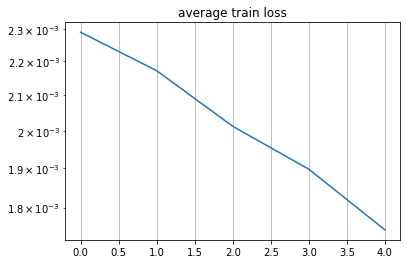

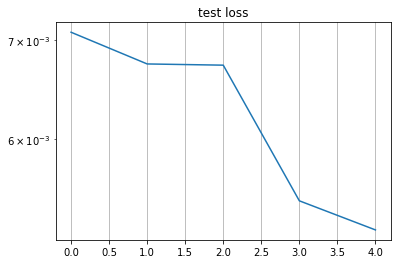

In [7]:
import matplotlib.pyplot as plt

n = 100

trloss = collect_train_loss[0:n]
teloss = collect_test_loss[0:n]

print(np.min(trloss),np.min(teloss))

n1 = len(trloss)
n2 = len(teloss)

plt.yscale('log')
plt.plot(np.arange(n1), trloss)
plt.grid()
plt.title('average train loss')
plt.show()

plt.yscale('log')
plt.plot(np.arange(n2), teloss)
plt.grid()
plt.title('test loss')
plt.show()

In [8]:
from torchsummary import summary
summary(model,(27,in_params["input_size"],in_params["input_size"]))

ModuleNotFoundError: No module named 'torchsummary'

In [8]:
# run the line below to save the model parameters
torch.save({'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': in_params['epochs']}, './model.pth')

In [ ]:
# two ways to add in latent space (combine2 looks more like what Titus' explained to us)
def combine(in1,in2,w,model):
  mu1, log_var1 = model.encode(in1)
  mu2, log_var2 = model.encode(in2)
  mu = w*mu1+(1-w)*mu2
  log_var = w*log_var1 + (1-w)*log_var2
  z = model.reparameterize(mu,log_var)
  return model.decode(z).detach()


def combine2(in1,in2,w,model):
  mu1, log_var1 = model.encode(in1)
  mu2, log_var2 = model.encode(in2)
  z1 = model.reparameterize(mu1,log_var1)
  z2 = model.reparameterize(mu2,log_var2)
  return model.decode(w*z1+(1-w)*z2).detach()